In [10]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM 
from tensorflow.keras import backend  
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [11]:
for dirname, _, filenames in os.walk('D:\\Coding\\Dataset\\pre-processed'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\Coding\Dataset\pre-processed\CICIDS_ALLATTACKS_BINARY.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_5_threshold_099.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_6_threshold_099.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_6_threshold_099.rar
D:\Coding\Dataset\pre-processed\Full_atk_zscore_7_threshold_098.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_7_threshold_099.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_7_threshold_099.rar
D:\Coding\Dataset\pre-processed\Full_atk_zscore_7_threshold_100.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_8_threshold_099.csv
D:\Coding\Dataset\pre-processed\Full_atk_zscore_9_threshold_099.csv
D:\Coding\Dataset\pre-processed\IDS_CNN.ipynb
D:\Coding\Dataset\pre-processed\logs.csv
D:\Coding\Dataset\pre-processed\.ipynb_checkpoints\IDS_CNN-checkpoint.ipynb


In [12]:
# Set up manual dataset
network_data = pd.read_csv('D:\\Coding\\Dataset\\pre-processed\\Full_atk_zscore_7_threshold_099.csv')

# Set up manual parameters for model

data_samples_value = 10000
random_value = 123

In [13]:
# check the columns in data
network_data.columns

# check the number of columns
print('Total columns in our data: %s' % str(len(network_data.columns)))

# check dataset info
network_data.info()

# check the number of values for labels
network_data['Label'].value_counts()

# check the number of values for labels
network_data['Label'].value_counts() 

Total columns in our data: 71
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214096 entries, 0 to 7214095
Data columns (total 71 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float64
 1   Protocol           float64
 2   Timestamp          float64
 3   Flow Duration      float64
 4   Tot Fwd Pkts       float64
 5   Tot Bwd Pkts       float64
 6   TotLen Fwd Pkts    float64
 7   TotLen Bwd Pkts    float64
 8   Fwd Pkt Len Max    float64
 9   Fwd Pkt Len Min    float64
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    float64
 13  Bwd Pkt Len Min    float64
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       float64
 21  Flow IAT Min       float64
 22  Fwd IAT Tot        float64
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        f

Label
Benign                      4836398
DDoS attacks-LOIC-HTTP       573347
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Brute Force -Web                350
Brute Force -XSS                116
SQL Injection                    78
Name: count, dtype: int64

In [14]:
cleaned_data = network_data 

# encode the column labels
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()


cleaned_data['Label'].value_counts()

Label
0     4836398
6      573347
8      439126
4      360833
1      285763
11     193354
14     187589
12     152874
9      139890
7       39924
10       2724
5        1730
2         350
3         116
13         78
Name: count, dtype: int64

In [15]:
# make 3 seperate datasets for 3 feature labels
data_Benign                 = cleaned_data[cleaned_data['Label'] == 0]
data_Bot                    = cleaned_data[cleaned_data['Label'] == 1]
data_BF_Web                 = cleaned_data[cleaned_data['Label'] == 2]
data_BF_XSS                 = cleaned_data[cleaned_data['Label'] == 3]
data_DDoS_HOIC              = cleaned_data[cleaned_data['Label'] == 4]
data_DDOS_LOIC_UDP          = cleaned_data[cleaned_data['Label'] == 5]
data_DDoS_LOIC_HTTP         = cleaned_data[cleaned_data['Label'] == 6]
data_DoS_GoldenEye          = cleaned_data[cleaned_data['Label'] == 7]
data_DoS_Hulk               = cleaned_data[cleaned_data['Label'] == 8]
data_DoS_SlowHTTPTest       = cleaned_data[cleaned_data['Label'] == 9]
data_DoS_Slowloris          = cleaned_data[cleaned_data['Label'] == 10]
data_FTP_BruteForce         = cleaned_data[cleaned_data['Label'] == 11]
data_Infilteration          = cleaned_data[cleaned_data['Label'] == 12]
data_SQL_Injection          = cleaned_data[cleaned_data['Label'] == 13]
data_SSH_Bruteforce         = cleaned_data[cleaned_data['Label'] == 14]


# make Benign feature
y_0 = np.zeros(data_Benign.shape[0])
y_Benign = pd.DataFrame(y_0)

# make Bot feature
y_1 = np.ones(data_Bot.shape[0])
y_Bot = pd.DataFrame(y_1)

# make Brute Force -Web attacks feature
y_2 = np.full(data_BF_Web.shape[0], 2)
y_BF_Web = pd.DataFrame(y_2)

# make Brute Force - XSS attacks feature
y_3 = np.full(data_BF_XSS.shape[0], 3)
y_BF_XSS = pd.DataFrame(y_3)

# make DDOS attack-HOIC attacks feature
y_4 = np.full(data_DDoS_HOIC.shape[0], 4)
y_DDoS_HOIC = pd.DataFrame(y_4)

# make DDoS attacks-LOIC-UDP attacks feature
y_5 = np.full(data_DDOS_LOIC_UDP.shape[0], 5)
y_DDOS_LOIC_UDP = pd.DataFrame(y_5)

# make DDoS attacks-LOIC-HTTP attacks feature
y_6 = np.full(data_DDoS_LOIC_HTTP.shape[0], 6)
y_DDoS_LOIC_HTTP = pd.DataFrame(y_6)

# make DoS attacks-GoldenEye attacks feature
y_7 = np.full(data_DoS_GoldenEye.shape[0], 7)
y_DoS_GoldenEye = pd.DataFrame(y_7)

# make DoS attacks-Hulk attacks feature
y_8 = np.full(data_DoS_Hulk.shape[0], 8)
y_DoS_Hulk = pd.DataFrame(y_8)

# make DoS attacks-SlowHTTPTest attacks feature
y_9 = np.full(data_DoS_SlowHTTPTest.shape[0], 9)
y_DoS_SlowHTTPTest = pd.DataFrame(y_9)

# make DoS attacks-Slowloris attacks feature
y_10 = np.full(data_DoS_Slowloris.shape[0], 10)
y_DoS_Slowloris = pd.DataFrame(y_10)

# make FTP-BruteForce attacks feature
y_11 = np.full(data_FTP_BruteForce.shape[0], 11)
y_FTP_BruteForce = pd.DataFrame(y_11)

# make Infilteration attacks feature
y_12 = np.full(data_Infilteration.shape[0], 12)
y_Infilteration = pd.DataFrame(y_12)

# make SQL Injection attacks feature
y_13 = np.full(data_SQL_Injection.shape[0], 13)
y_SQL_Injection = pd.DataFrame(y_13)

# make SSH-Bruteforce attacks feature
y_14 = np.full(data_SSH_Bruteforce.shape[0], 14)
y_SSH_Bruteforce = pd.DataFrame(y_14)

# merging the original dataframe
X = pd.concat([data_Benign, data_Bot, data_BF_Web, data_BF_XSS, data_DDoS_HOIC, 
               data_DDOS_LOIC_UDP, data_DDoS_LOIC_HTTP, data_DoS_GoldenEye, data_DoS_Hulk, data_DoS_SlowHTTPTest, 
               data_DoS_Slowloris, data_FTP_BruteForce, data_Infilteration, data_SQL_Injection, data_SSH_Bruteforce], 
               sort=True)
y = pd.concat([y_Benign, y_Bot, y_BF_Web, y_BF_XSS, y_DDoS_HOIC, y_DDOS_LOIC_UDP,
               y_DDoS_LOIC_HTTP, y_DoS_GoldenEye, y_DoS_Hulk, y_DoS_SlowHTTPTest,
               y_DoS_Slowloris, y_FTP_BruteForce, y_Infilteration, y_SQL_Injection,
               y_SSH_Bruteforce], sort=True)


In [16]:
print(X.shape)
print(y.shape)

(7214096, 71)
(7214096, 1)


In [17]:
# Create data samples for each label
from sklearn.utils import resample

data_resample_Benign = resample(data_Benign, n_samples = data_samples_value, 
                                random_state = random_value, replace = True)
data_resample_Bot = resample(data_Bot, n_samples = data_samples_value, 
                             random_state = random_value, replace = True)
data_resample_BF_Web = resample(data_BF_Web, n_samples = 350, 
                                random_state = random_value, replace = True)
data_resample_BF_XSS = resample(data_BF_XSS, n_samples = 116, 
                                random_state = random_value, replace = True)
data_resample_DDoS_HOIC = resample(data_DDoS_HOIC, n_samples = data_samples_value, 
                                   random_state = random_value, replace = True)
data_resample_DDOS_LOIC_UDP = resample(data_DDOS_LOIC_UDP, n_samples = 1730, 
                                       random_state = random_value, replace = True)
data_resample_DDoS_LOIC_HTTP = resample(data_DDoS_LOIC_HTTP, n_samples = data_samples_value, 
                                        random_state = random_value, replace = True)
data_resample_DoS_GoldenEye = resample(data_DoS_GoldenEye, n_samples = data_samples_value, 
                                       random_state = random_value, replace = True)
data_resample_DoS_Hulk = resample(data_DoS_Hulk, n_samples = data_samples_value, 
                                  random_state = random_value, replace = True)
data_resample_DoS_SlowHTTPTest = resample(data_DoS_SlowHTTPTest, n_samples = data_samples_value, 
                                          random_state = random_value, replace = True)
data_resample_DoS_Slowloris = resample(data_DoS_Slowloris, n_samples = 2724, 
                                       random_state = random_value, replace = True)
data_resample_FTP_BruteForce = resample(data_FTP_BruteForce, n_samples = data_samples_value, 
                                        random_state = random_value, replace = True)
data_resample_Infilteration = resample(data_Infilteration, n_samples = data_samples_value, 
                                       random_state = random_value, replace = True)
data_resample_SQL_Injection = resample(data_SQL_Injection, n_samples = 78, 
                                       random_state = random_value, replace = True)
data_resample_SSH_Bruteforce = resample(data_SSH_Bruteforce, n_samples = data_samples_value, 
                                        random_state = random_value, replace = True)


# Concatenate samples
train_dataset = pd.concat([data_resample_Benign, data_resample_Bot, data_resample_BF_Web, data_resample_BF_XSS, 
                           data_resample_DDoS_HOIC, data_resample_DDOS_LOIC_UDP, data_resample_DDoS_LOIC_HTTP, 
                           data_resample_DoS_GoldenEye, data_resample_DoS_Hulk, data_resample_DoS_SlowHTTPTest, 
                           data_resample_DoS_Slowloris, data_resample_FTP_BruteForce, data_resample_Infilteration, 
                           data_resample_SQL_Injection, data_resample_SSH_Bruteforce], 
                          ignore_index=True)

In [18]:
# Create test dataset with amount parameter

test_samples_fraction_value = 0.1

test_dataset = train_dataset.sample(frac = test_samples_fraction_value)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 1,  0, 11, 14,  8, 10,  4,  9,  3,  7, 12,  6,  5, 13,  2]))

In [19]:
y_train = to_categorical(target_train, num_classes=15)  
y_test = to_categorical(target_test, num_classes=15)

In [20]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

In [21]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test

array([[1.23294778e-01, 8.85083665e-05, 3.83877159e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.08752842e-04, 1.29333346e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.23294778e-01, 4.95000186e-06, 1.91938580e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.22074038e-03, 1.63052753e-02, 4.18410042e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.06254817e-01, 3.52628995e-01, 3.75000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22074038e-03, 8.38500028e-05, 3.22968207e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [22]:
# Check tran and test samples

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(104998, 63)
(10500, 63)
(104998, 15)
(10500, 15)


In [23]:
# reshape the data for CNN
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)



# Check shape
X_train.shape 
X_test.shape

# Automate model parameter

feature_value = X_train.shape[1]

In [24]:
X_train.shape 
X_test.shape

(10500, 63, 1)

In [25]:
# making the deep learning function for CNN
def model():
    inputs = Input(shape=(feature_value,1))
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', #Convolutional layers learn local patterns within the data.
                    padding='same', input_shape=(feature_value, 1))) 
    model.add(BatchNormalization()) #Batch normalization helps stabilize the training process by normalizing activations across each mini-batch. This can lead to faster convergence and better generalization.
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same')) #Downsampling layers reduce dimensionality and increase the model's receptive field (the region of the input that affects a neuron's output).
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(feature_value, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(feature_value, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten()) #eshapes the multidimensional data into a single vector.
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu')) # Fully connected layers, where each neuron connects to every output from the previous layer. 
    model.add(Dense(15, activation='softmax')) #The output layer with two neurons, matching the number of classes in your classification problem (assuming binary classification). 'softmax' gives probability-like outputs, ensuring the class predictions sum to 1.
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
# Create a model 
model_instance = model()

# Summarize model parameter
model_instance.summary()

d:\Coding\Python\Python 3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 63, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,463 (345.56 KB)

 Trainable params: 88,079 (344.06 KB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
# Run model and save a log file

logger = CSVLogger('logs.csv', append=True)
his = model_instance.fit(X_train, y_train, epochs=100, batch_size=48, validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9216 - loss: 0.2486 - val_accuracy: 0.6259 - val_loss: 1.6567
Epoch 2/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9711 - loss: 0.0752 - val_accuracy: 0.9549 - val_loss: 0.0992
Epoch 3/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9748 - loss: 0.0654 - val_accuracy: 0.9152 - val_loss: 0.1835
Epoch 4/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9787 - loss: 0.0565 - val_accuracy: 0.9782 - val_loss: 0.0730
Epoch 5/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9816 - loss: 0.0502 - val_accuracy: 0.9825 - val_loss: 0.0468
Epoch 6/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9829 - loss: 0.0460 - val_accuracy: 0.8615 - val_loss: 0.4964
Epoch 7/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9834 - loss: 0.0439 - val_accuracy: 0.9852 - val_loss: 0.0387
Epoch 8/100
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9854 - loss: 0

In [28]:
# check the model performance on test data

scores_cnn = model_instance.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model_instance.metrics_names[1], scores_cnn[1] * 100))

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9943 - loss: 0.0184
compile_metrics: 99.51%


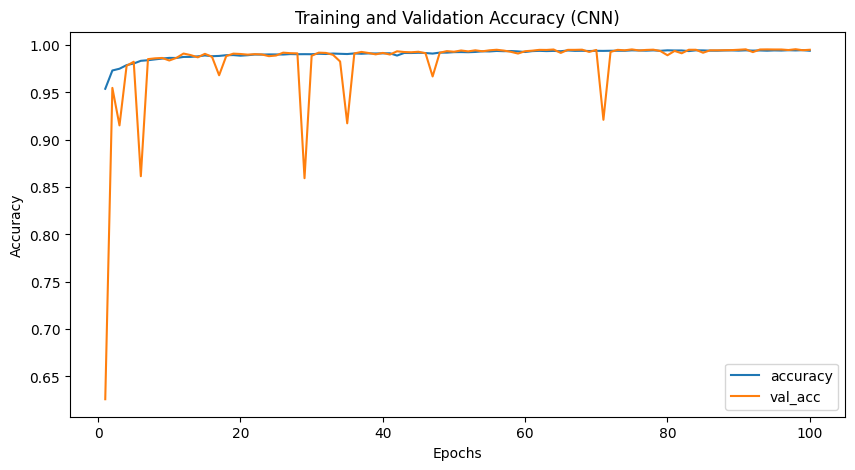

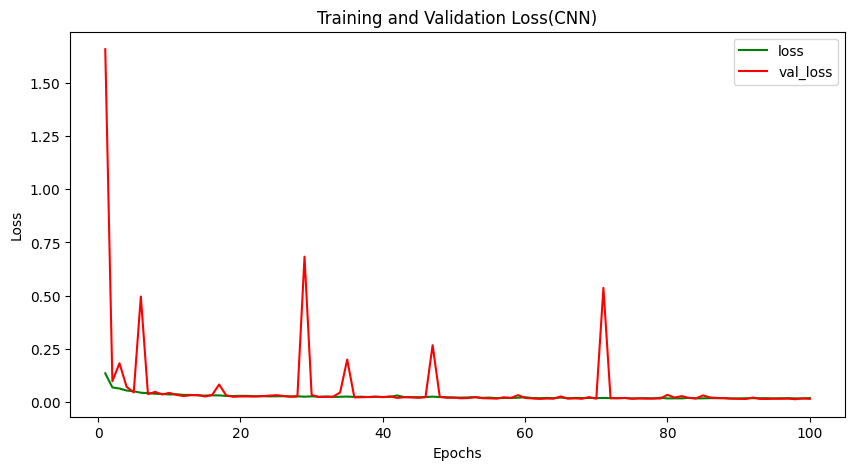

In [29]:
# check history of model
history = his.history


epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [30]:
# Save the model

model_instance.save('IDS_model.h5')

print("Model saved successfully.")

Model saved successfully.
